In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from sklearn.metrics import accuracy_score

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define transformations for train, validation, and test data
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Load datasets
data_dir = '/home/jovyan/Data Mining and Machine Learning/Dataset_New'
datasets_dict = {
    x: datasets.ImageFolder(root=f"{data_dir}/{x}", transform=data_transforms[x])
    for x in ['train', 'val', 'test']
}
dataloaders = {x: DataLoader(datasets_dict[x], batch_size=32, shuffle=True, num_workers=4)
               for x in ['train', 'val', 'test']}

# Define the ResNet model with modifications for binary classification
model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # Binary classification
model = model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)



/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [2]:
# Training the model
num_epochs = 10
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders[phase]:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(datasets_dict[phase])
        epoch_acc = running_corrects.double() / len(datasets_dict[phase])

        print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

# Save the model after training
torch.save(model.state_dict(), 'resnet50_liveness_detection.pth')
print("Model saved successfully!")


Epoch 1/10


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


train Loss: 0.3103 Acc: 0.8824
val Loss: 0.2504 Acc: 0.9290
Epoch 2/10
train Loss: 0.2192 Acc: 0.9113
val Loss: 0.2922 Acc: 0.8752
Epoch 3/10
train Loss: 0.1568 Acc: 0.9418
val Loss: 0.1516 Acc: 0.9435
Epoch 4/10
train Loss: 0.1287 Acc: 0.9493
val Loss: 0.5205 Acc: 0.8384
Epoch 5/10
train Loss: 0.1018 Acc: 0.9613
val Loss: 0.2223 Acc: 0.9001
Epoch 6/10
train Loss: 0.1162 Acc: 0.9553
val Loss: 0.1091 Acc: 0.9632
Epoch 7/10
train Loss: 0.0835 Acc: 0.9662
val Loss: 0.1868 Acc: 0.9382
Epoch 8/10
train Loss: 0.0782 Acc: 0.9715
val Loss: 0.1522 Acc: 0.9435
Epoch 9/10
train Loss: 0.0882 Acc: 0.9662
val Loss: 0.1443 Acc: 0.9422
Epoch 10/10
train Loss: 0.0738 Acc: 0.9715
val Loss: 0.1193 Acc: 0.9606
Model saved successfully!


In [3]:

model = models.resnet50(pretrained=False)  # Define the architecture
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # Adjust for binary classification
model.load_state_dict(torch.load('resnet50_liveness_detection.pth'))  # Load the trained weights
model = model.to(device)
model.eval()  # Set the model to evaluation mode

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate accuracy
test_accuracy = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.9770


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


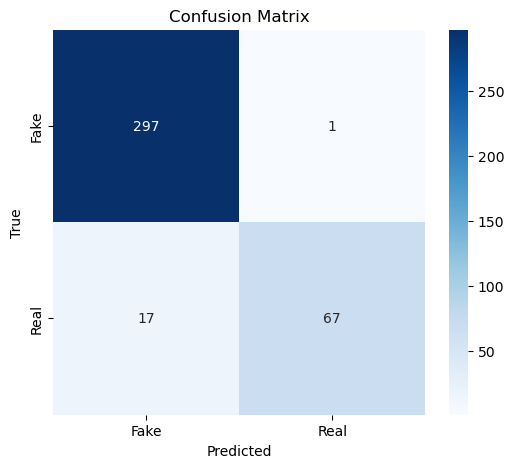

Test Accuracy: 0.9529


In [3]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from torchvision import models
import torch.nn as nn

# Load the model and set it to evaluation mode
model = models.resnet50(pretrained=False)  # Define the architecture
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # Adjust for binary classification
model.load_state_dict(torch.load('resnet50_liveness_detection.pth'))  # Load the trained weights
model = model.to(device)
model.eval()  # Set the model to evaluation mode

all_preds = []
all_labels = []

# Variables to track total inference time
total_inference_time = 0
total_images = 0

with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Perform inference
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        # Collect predictions and labels for accuracy and confusion matrix calculation
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Calculate accuracy
test_accuracy = (cm[0, 0] + cm[1, 1]) / cm.sum()
print(f"Test Accuracy: {test_accuracy:.4f}")
